# Figure 4: Adhesome TFs

In [1]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from upsetplot import from_contents, UpSet
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
import pyvis as pv
from pyvis.network import Network
from pyvis import network as net
import xlmhg
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/analysis4_adhesome_tfs/correlation_clustering.py'>

In [2]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'
norm = 'GWKR'
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))

In [3]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of processed HiC
dir_processed_hic = f'/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_inter{norm}/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_IMR90/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_regulatory_marks/processed_epigenome_data_IMR90/'
# Directpry of TF target data
dir_htftarget = '/home/louiscam/projects/gpcr/data/tf_data/hTFtarget/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
saving_main_dir = '/home/louiscam/projects/gpcr/save/figures_main/'
saving_supp_dir = '/home/louiscam/projects/gpcr/save/figures_supplement/'

# Load gene data

In [4]:
# Gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)
df_loc['geneLength'] = df_loc['chromEnd']-df_loc['chromStart']
genes_df = df_loc[['geneSymbol', 'geneLength']].set_index('geneSymbol')

In [5]:
# Mapping gene to chromosome
with open(saving_dir+'gene2chrom.pkl', 'rb') as f:
    gene2chrom = pickle.load(f)

In [6]:
# Mapping from gene to locus
with open(saving_dir+'gene2locus.pkl', 'rb') as f:
    gene2locus = pickle.load(f)

In [7]:
# Active/inactive loci (from clustering)
with open(saving_dir+'all_active_loci.pkl', 'rb') as f:
    all_active_loci_from_clustering = pickle.load(f)
with open(saving_dir+'all_inactive_loci.pkl', 'rb') as f:
    all_inactive_loci_from_clustering = pickle.load(f)

# Active/inactive genes (from clustering)
with open(saving_dir+'active_genes.pkl', 'rb') as f:
    active_genes = pickle.load(f)
with open(saving_dir+'inactive_genes.pkl', 'rb') as f:
    inactive_genes = pickle.load(f)
all_genes = np.concatenate([active_genes, inactive_genes])

# Define active/inactive loci as the loci of active/inactive genes
with open(saving_dir+'gene2locus.pkl', 'rb') as f:
    gene2locus = pickle.load(f)
all_active_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in active_genes])))
all_inactive_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in inactive_genes])))

# Redefine all active loci as the intersection between active loci determined directly by clustering'
# and all loci of active genes
# all_active_loci = np.unique(list(set(all_active_loci).intersection(set(all_active_loci_from_clustering))))
# all_inactive_loci = np.array(list(set(all_inactive_loci)-set(all_active_loci)))

In [8]:
# TF genes
with open(saving_dir+'active_lung_adhesome_tf_genes.pkl', 'rb') as f:
    active_lung_adhesome_tf_genes = pickle.load(f)

In [9]:
# Adhesome genes
with open(saving_dir+'active_adhesome_loci.pkl', 'rb') as f:
    active_adhesome_loci = pickle.load(f)
with open(saving_dir+'inactive_adhesome_loci.pkl', 'rb') as f:
    inactive_adhesome_loci = pickle.load(f)
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
with open(saving_dir+'inactive_adhesome_genes.pkl', 'rb') as f:
    inactive_adhesome_genes = pickle.load(f)
with open(saving_dir+'adhesome_chr_loci.pkl', 'rb') as f:
    adhesome_chr_loci = pickle.load(f)
all_adhesome_genes = np.concatenate([active_adhesome_genes,inactive_adhesome_genes])

# Breakdown of TFs

In [10]:
# Load TFs
tftarget_df = pd.read_csv(dir_htftarget+'tftarget_full_processed.csv', 
                          sep='\t', index_col=0, header=0, low_memory=False)
# Restrict tftarget_df to protein coding genes used in our analysis
tftarget_df = tftarget_df[tftarget_df['tf'].isin(all_genes)]
tftarget_df = tftarget_df[tftarget_df['target_gene'].isin(all_genes)]

# Select only TF-target pairs in lung fibroblasts
all_lung_cell_lines = tftarget_df[tftarget_df['tissue']=='lung']['cell_line'].unique()
lung_fibroblasts = ['IMR90', 'WI38', 'AG04450', 'HPF', 'NHLF']
tftarget_df_lungfibro = tftarget_df[tftarget_df['cell_line'].isin(lung_fibroblasts)]

In [11]:
# TFs targeting adhesome
tftarget_df_lungfibro['active adhesome target'] = tftarget_df_lungfibro['target_gene'].isin(active_adhesome_genes)
tftarget_df_lungfibro['active tf'] = tftarget_df_lungfibro['tf'].isin(active_genes)
tftarget_df_lungfibro_simple = tftarget_df_lungfibro[['tf', 'target_gene', 'active tf', 'active adhesome target']]
tftarget_df_lungfibro_simple = tftarget_df_lungfibro_simple.drop_duplicates(subset=['tf', 'target_gene'], keep='first')

<Figure size 360x360 with 0 Axes>

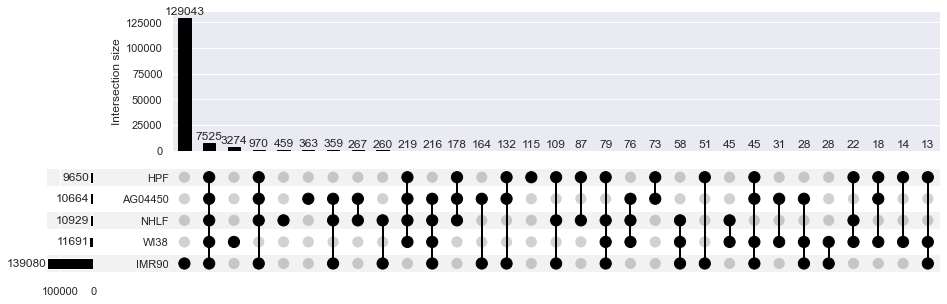

In [12]:
# Compare the tf-target links from different cell lines
df_comp = tftarget_df_lungfibro.copy()
df_comp['tftarget'] = df_comp[['tf', 'target_gene']].agg('_'.join, axis=1)
df_comp = df_comp[['tf', 'target_gene', 'tftarget', 'cell_line']]
dict_comp = {}
for cl in lung_fibroblasts:
    dict_comp[cl] = df_comp[df_comp['cell_line']==cl]['tftarget'].unique()
intersections = from_contents(dict_comp)

sns.set(font_scale=1)
plt.figure(figsize=(5,5))
upset = UpSet(intersections, subset_size='count', show_counts = True, 
              sort_by="cardinality", min_subset_size = 1).plot()
plt.savefig(saving_supp_dir+f'suppfig_5b.pdf', format='pdf')
plt.show()

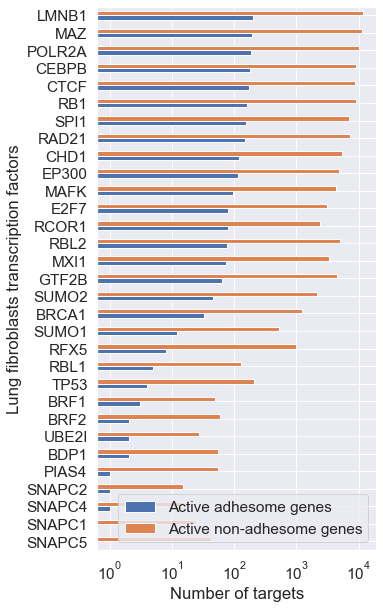

In [13]:
# Plot number of targets per TF
df = tftarget_df_lungfibro_simple[tftarget_df_lungfibro_simple['target_gene'].isin(active_genes)]
df = df.groupby(
    ['tf','active adhesome target']
)['active adhesome target'].count().unstack().fillna(0).sort_values(by=[True])
df.columns.name = 'Target'
df.columns = ['Active non-adhesome genes', 'Active adhesome genes']
df = df[['Active adhesome genes', 'Active non-adhesome genes']]

sns.set(font_scale=1.4)
df.plot.barh(figsize=(5,10))
plt.xscale('log')
plt.xlabel('Number of targets')
plt.ylabel('Lung fibroblasts transcription factors')
# plt.savefig(saving_main_dir+f'fig_4a.pdf', format='pdf')
plt.show()

In [14]:
# Examine how many active genes each TF targets
df = tftarget_df_lungfibro_simple[tftarget_df_lungfibro_simple['target_gene'].isin(active_genes)]
df.drop_duplicates(['tf', 'target_gene']).groupby('tf')['target_gene'].count().sort_values()

tf
SNAPC4       16
SNAPC2       16
SNAPC1       24
UBE2I        29
SNAPC5       42
BRF1         52
PIAS4        56
BDP1         57
BRF2         61
RBL1        133
TP53        211
SUMO1       536
RFX5        981
BRCA1      1266
SUMO2      2205
RCOR1      2496
E2F7       3190
MXI1       3393
MAFK       4357
GTF2B      4502
EP300      5025
RBL2       5165
CHD1       5543
SPI1       7200
RAD21      7513
CTCF       9039
RB1        9256
CEBPB      9390
POLR2A    10169
MAZ       11374
LMNB1     12164
Name: target_gene, dtype: int64

##### Adhesome genes targeted by TFs

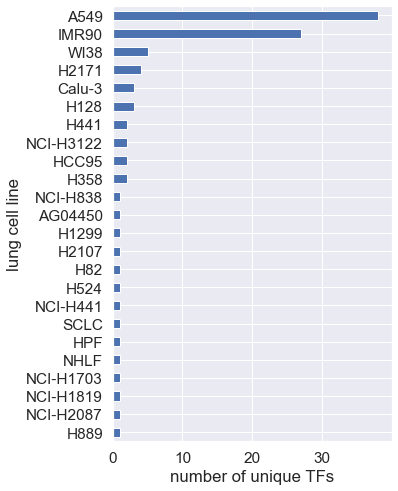

In [15]:
# Plot number of unique TFs present in different lung cell lines
sns.set(font_scale=1.4)
tftarget_df[tftarget_df['tissue']=='lung'].groupby(['cell_line'])['tf'].nunique().sort_values().plot.barh(figsize=(5,8))
plt.xlabel('number of unique TFs')
plt.ylabel('lung cell line')
plt.show()

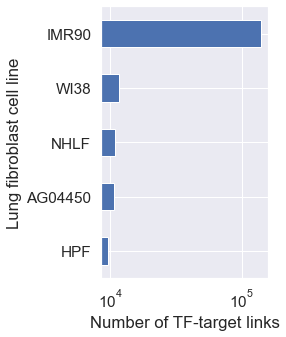

In [16]:
# Plot number of TF-target links present in different lung cell lines
sns.set(font_scale=1.4)
#tftarget_df[tftarget_df['tissue']=='lung'].drop_duplicates(subset=['tf', 'target_gene', 'cell_line'], keep='first').groupby(['cell_line'])['tf'].count().sort_values().plot.barh(figsize=(5,8))
tftarget_df[(tftarget_df['tissue']=='lung') & (tftarget_df['cell_line'].isin(lung_fibroblasts))].drop_duplicates(subset=['tf', 'target_gene', 'cell_line'], keep='first').groupby(['cell_line'])['tf'].count().sort_values().plot.barh(figsize=(3,5))
plt.xscale('log')
plt.xlabel('Number of TF-target links')
plt.ylabel('Lung fibroblast cell line')
# plt.savefig(saving_supp_dir+f'suppfig_5a.pdf', format='pdf')
plt.show()

In [17]:
# TFs present in the different lung fibroblast cell lines
tfs_present = tftarget_df[
    (tftarget_df['tissue']=='lung') & 
    (tftarget_df['cell_line'].isin(lung_fibroblasts))
].drop_duplicates(
    subset=['tf', 'target_gene', 'cell_line'], keep='first'
).groupby(['cell_line'])['tf'].unique()
tfs_present

cell_line
AG04450                                               [CTCF]
HPF                                                   [CTCF]
IMR90      [LMNB1, RBL2, MAFK, BRF2, RB1, E2F7, CHD1, EP3...
NHLF                                                  [CTCF]
WI38                      [SUMO2, UBE2I, PIAS4, SUMO1, CTCF]
Name: tf, dtype: object

In [18]:
# Brief overview of the TFs we select
all_lungfib_tfs = tftarget_df_lungfibro_simple.groupby(
    ['tf','active adhesome target'])['active adhesome target'].count().unstack().index.values
print('Inactive TFs = '+str(set(all_lungfib_tfs)-
                            set([x for x in all_lungfib_tfs if x in active_genes])))
print('Active TFs targeting inactive adhesome genes = '+str(set([x for x in all_lungfib_tfs if x in active_genes])-
                                                            set(active_lung_adhesome_tf_genes)))

Inactive TFs = {'SNAPC4', 'CHD1', 'SPI1'}
Active TFs targeting inactive adhesome genes = {'SNAPC1', 'SNAPC5'}


In [19]:
# Obtain proportion of genome/adhesome targets of each adhesome TF in different cell lines
selected_cell_lines = ['IMR90', 'WI38', 'AG04450', 'HPF', 'NHLF']
adhesome_tftarget_df = tftarget_df[(tftarget_df['tf'].isin(active_lung_adhesome_tf_genes)) &
                                   (tftarget_df['cell_line'].isin(selected_cell_lines))]
# Obtain proportion of active genome targets or each adhesome TF
prop_genome_df = adhesome_tftarget_df[adhesome_tftarget_df['target_gene'].isin(active_genes)]
prop_genome_df = prop_genome_df.drop_duplicates(subset=['tf', 'target_gene'], keep='first')
prop_genome_df = prop_genome_df.groupby(['tf'])
prop_genome_df = prop_genome_df['target_gene'].nunique()/len(active_genes)
prop_genome_df = prop_genome_df.reset_index().set_index('tf')
prop_genome_df.columns = ['prop_genome_targets']
# Obtain proportion of active adhesome targets or each adhesome TF
prop_adhesome_df = adhesome_tftarget_df[adhesome_tftarget_df['target_gene'].isin(active_adhesome_genes)]
prop_adhesome_df = prop_adhesome_df.drop_duplicates(subset=['tf', 'target_gene'], keep='first')
prop_adhesome_df = prop_adhesome_df.groupby(['tf'])
prop_adhesome_df = prop_adhesome_df['target_gene'].nunique()/len(active_adhesome_genes)
prop_adhesome_df = prop_adhesome_df.reset_index().set_index('tf')
prop_adhesome_df.columns = ['prop_adhesome_targets']
# Combine to dataframe
tf_char_df = prop_genome_df.join(prop_adhesome_df, how='outer')

In [20]:
# Hypergeometric confidence interval

# Hypergeometric parameters N and K
N = len(active_genes) # total number of active genes
K = len(active_adhesome_genes) # total number of active adhesome genes

# Sequence of hyper geometric parameter n
q_list = np.logspace(-4,0,1000)
n_list = [int(q*N) for q in q_list]

# Lower and upper bound of (right-sided) CI
alpha = 0.05/len(active_lung_adhesome_tf_genes) # level of confidence interval
ci_lowerbound = np.repeat(0, len(q_list))
ci_upperbound = np.array([ss.hypergeom.ppf(1-alpha, N, K, n, loc=0) for n in n_list])/K

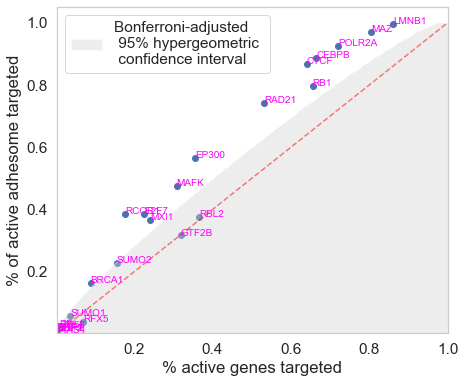

In [21]:
# Plot TFs on prop_genome_targets - prop_adhesome_targets space
sns.set(font_scale=1.4)
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots(figsize=(7,6))
x = tf_char_df['prop_genome_targets']
y = tf_char_df['prop_adhesome_targets']
labels = tf_char_df.index.values
ax.scatter(x, y)
ax.plot((0,1),(0,1), color='red', linestyle='dashed', alpha=0.5)
ax.fill_between(q_list, ci_lowerbound, ci_upperbound, where=None, facecolor='lightgrey', 
                interpolate=False, alpha=0.4, 
                label='Bonferroni-adjusted \n 95% hypergeometric \n confidence interval')
for i in range(tf_char_df.shape[0]):
    ax.annotate(labels[i], (x[i], y[i]), size=10, color='magenta')
plt.xlabel('% active genes targeted')
plt.ylabel('% of active adhesome targeted')
plt.legend(loc='upper left')
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([4e-3,1])
plt.ylim([3e-3,1.05])
plt.savefig(saving_main_dir+f'fig_4c.pdf', format='pdf')
plt.show()

In [22]:
# Compute adjusted p-values
pvals = [ss.hypergeom.sf(tf_char_df.loc[tf,'prop_adhesome_targets']*K, 
                         N, 
                         K, 
                         tf_char_df.loc[tf,'prop_genome_targets']*N)*len(active_lung_adhesome_tf_genes)
         for tf in tf_char_df.index]
tf_char_df = pd.concat(
    [tf_char_df, pd.DataFrame({'adj_pval': pvals}, index=tf_char_df.index)], 
    axis=1
)
tf_char_df['adj_pval'] = tf_char_df['adj_pval'].fillna(1)

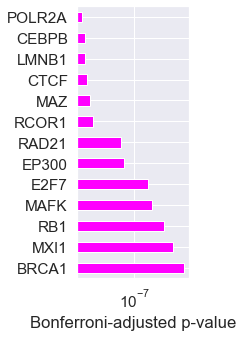

Number of significant TFs = 13


In [23]:
# Barplot of significant adhesome TFs
tf_char_df = tf_char_df.sort_values(by='adj_pval', ascending=False)

sns.set(font_scale=1.4)
plt.figure(figsize=(2,5))
tf_char_df[tf_char_df['adj_pval']<0.05]['adj_pval'].plot.barh(color='magenta')
plt.xscale('log')
plt.xlabel('Bonferroni-adjusted p-value')
plt.ylabel('')
# plt.title('Significant active lung fibroblast TFs \n targeting active adhesome genes')
plt.savefig(saving_main_dir+f'fig_4d.pdf', format='pdf')
plt.show()
significant_tfs = tf_char_df[tf_char_df['adj_pval']<0.05].index.values
print(f'Number of significant TFs = {len(significant_tfs)}')

# TF network

In [24]:
# Obtain TF network for the adhesome in lung fibroblasts
tf_edgelist_lungfibro = tftarget_df_lungfibro[['tf','target_gene']]
tf_edgelist_lungfibro = tf_edgelist_lungfibro[(tf_edgelist_lungfibro['tf'].isin(active_lung_adhesome_tf_genes)) & 
                                    (tf_edgelist_lungfibro['target_gene'].isin(active_lung_adhesome_tf_genes))]
tf_edgelist_lungfibro.columns = ['source', 'target']
G_lung = nx.from_pandas_edgelist(tf_edgelist_lungfibro, create_using=nx.DiGraph)
nx.set_node_attributes(G_lung, {tf: int(tf in significant_tfs) for tf in G_lung.nodes}, 'significant_tf')
nx.set_node_attributes(G_lung, nx.eigenvector_centrality(G_lung.reverse()), 'eigenvector_centrality')
nx.set_node_attributes(G_lung, nx.pagerank(G_lung.reverse(), alpha=0.9), 'pagerank_centrality')
phi = np.max(np.abs(np.linalg.eigh(np.array(nx.adjacency_matrix(G_lung).todense()))[0]))
nx.set_node_attributes(G_lung, nx.katz_centrality(G_lung.reverse(), alpha=1/phi-0.01), 'katz_centrality')
tf_net_summary = pd.DataFrame({'number of TFs': [len(G_lung.nodes)],
                               'number of edges': [len(G_lung.edges)],
                               'density': [nx.density(G_lung)]})
print(tf_net_summary)

   number of TFs  number of edges   density
0             26              242  0.372308


In [25]:
reload(cc)
# Define network object
net  = Network(height="1000px",
               width="1000px",
               directed=True,
               font_color='black',
               notebook=True,
               layout=None,
               heading='Adhesome TF network')

# Set layout
net.hrepulsion(node_distance=200,
               central_gravity=0.0,
               spring_length=100,
               spring_strength=0.01,
               damping=0.09)

net.toggle_physics(True)

# Import NetworkX graph
cc.tfnx_from_nx(G_lung, net, 
                default_node_size=40, default_edge_weight=2,
                shape='box')
#net.show_buttons()
net.show("adhesome_tf_network.html")

<Figure size 432x288 with 0 Axes>

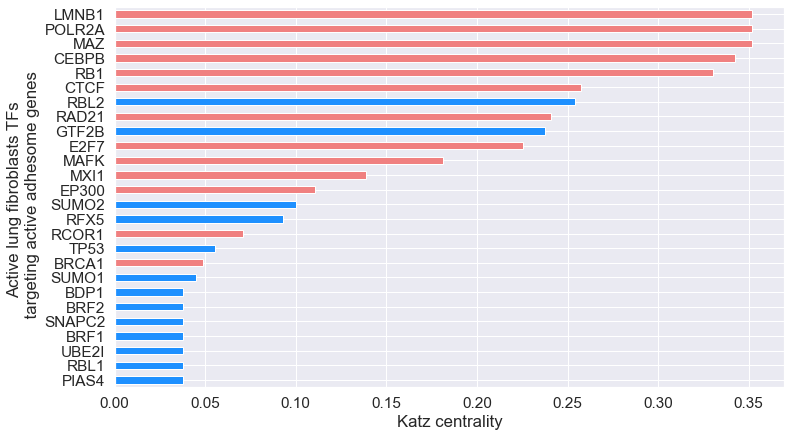

In [26]:
# Compare centrality of significant TFs
centrality_df = oi.get_networkx_graph_as_dataframe_of_nodes(G_lung)
centrality_df = centrality_df.sort_values('katz_centrality', ascending=True)
plt.figure()
centrality_df.plot.barh(y='katz_centrality', 
                        color=np.array(['dodgerblue', 'lightcoral'])[centrality_df['significant_tf'].values],
                        legend=False,
                        figsize=(12,7))
plt.xlabel('Katz centrality')
plt.ylabel('Active lung fibroblasts TFs \n targeting active adhesome genes')
# plt.savefig(saving_supp_dir+f'suppfig_15a.pdf', format='pdf')
plt.show()

In [27]:
# Perform XL-mHG test for enrichment of significant TFs at the top of the list sorted by Katz centrality
v = centrality_df.sort_values('katz_centrality', ascending=False)['significant_tf'].values
X = int(np.round(0.1*len(significant_tfs),0)) # minimum number of “1’s” that have to be 
                                              # seen before anything can be called “enrichment”
L = int(np.round(1.5*len(significant_tfs),0)) # lowest cutoff that is being tested for enrichment
stat, cutoff, pval = xlmhg.xlmhg_test(v, X=X, L=L)
print(f'Number of significant TFs = {len(significant_tfs)}')
print(f'X = {X}')
print(f'L = {L}')
print(f'stat={stat}, cutoff={cutoff}, pval={pval}')

Number of significant TFs = 13
X = 1
L = 20
stat=0.000601311462800223, cutoff=13, pval=0.0014374170720919948


# Check co-clustering with adhesome genes

## Co-clustering using adhesome TF-target links only

In [105]:
# Import list of all blacklisted loci
with open(dir_processed_hic+f'blacklist_IMR90_{norm}.pickle', 'rb') as f:
    blacklist_list = pickle.load(f)

In [110]:
# Create dataframe mapping each TF locus to the loci of its target adhesome genes
tf2target_df_adhesome = tftarget_df_lungfibro_simple[
    tftarget_df_lungfibro_simple['active tf'] & 
    tftarget_df_lungfibro_simple['active adhesome target']
]
tf2target_df_adhesome.loc[:, 'tf_loc'] = tf2target_df_adhesome.apply(
    lambda row: gene2locus[row['tf']], axis=1
)
tf2target_df_adhesome.loc[:, 'target_loc'] = tf2target_df_adhesome.apply(
    lambda row: gene2locus[row['target_gene']], axis=1
)
tf2target_df_adhesome = tf2target_df_adhesome[['tf_loc', 'target_loc']]
tf2target_df_adhesome = tf2target_df_adhesome.explode('tf_loc')
tf2target_df_adhesome = tf2target_df_adhesome.explode('target_loc')
tf2target_df_adhesome = tf2target_df_adhesome[
    (~tf2target_df_adhesome['tf_loc'].isin(blacklist_list)) & 
    (~tf2target_df_adhesome['target_loc'].isin(blacklist_list))
]

# Location of TF and target genes
tf2target_df_adhesome.loc[:, 'tf_chrom'] = tf2target_df_adhesome.apply(
    lambda row: int(row['tf_loc'].split('_')[1]), axis=1
)
tf2target_df_adhesome.loc[:, 'tf_locus'] = tf2target_df_adhesome.apply(
    lambda row: int(row['tf_loc'].split('_')[3]), axis=1
)
tf2target_df_adhesome.loc[:, 'target_chrom'] = tf2target_df_adhesome.apply(
    lambda row: int(row['target_loc'].split('_')[1]), axis=1
)
tf2target_df_adhesome.loc[:, 'target_locus'] = tf2target_df_adhesome.apply(
    lambda row: int(row['target_loc'].split('_')[3]), axis=1
)
tf2target_df_adhesome = tf2target_df_adhesome.reset_index(drop=True)

selected_adhesome_tf_loci = tf2target_df_adhesome['tf_loc'].unique()
print(f'Number of selected adhesome TF loci = {len(selected_adhesome_tf_loci)}')

Number of selected adhesome TF loci = 29


In [111]:
# Note: check if there is overlap between adhesome TF loci and active adhesome loci
set.intersection(*[set(selected_adhesome_tf_loci), set(active_adhesome_loci)])

set()

In [112]:
# Create dataframe mapping each TF locus to the loci of its target non-adhesome genes
tf2target_df_nonadhesome = tftarget_df_lungfibro_simple[
    tftarget_df_lungfibro_simple['active tf'] & 
    (~tftarget_df_lungfibro_simple['active adhesome target']) &
    tftarget_df_lungfibro_simple['target_gene'].isin(active_genes)
]
tf2target_df_nonadhesome.loc[:, 'tf_loc'] = tf2target_df_nonadhesome.apply(
    lambda row: gene2locus[row['tf']], axis=1
)
tf2target_df_nonadhesome.loc[:, 'target_loc'] = tf2target_df_nonadhesome.apply(
    lambda row: gene2locus[row['target_gene']], axis=1
)
tf2target_df_nonadhesome = tf2target_df_nonadhesome[['tf_loc', 'target_loc']]
tf2target_df_nonadhesome = tf2target_df_nonadhesome.explode('tf_loc')
tf2target_df_nonadhesome = tf2target_df_nonadhesome.explode('target_loc')
tf2target_df_nonadhesome = tf2target_df_nonadhesome[
    (tf2target_df_nonadhesome['tf_loc'].isin(selected_adhesome_tf_loci)) &
    (~tf2target_df_nonadhesome['tf_loc'].isin(blacklist_list)) & 
    (~tf2target_df_nonadhesome['target_loc'].isin(blacklist_list))
]

# Location of TF and target genes
tf2target_df_nonadhesome.loc[:, 'tf_chrom'] = tf2target_df_nonadhesome.apply(
    lambda row: int(row['tf_loc'].split('_')[1]), axis=1
)
tf2target_df_nonadhesome.loc[:, 'tf_locus'] = tf2target_df_nonadhesome.apply(
    lambda row: int(row['tf_loc'].split('_')[3]), axis=1
)
tf2target_df_nonadhesome.loc[:, 'target_chrom'] = tf2target_df_nonadhesome.apply(
    lambda row: int(row['target_loc'].split('_')[1]), axis=1
)
tf2target_df_nonadhesome.loc[:, 'target_locus'] = tf2target_df_nonadhesome.apply(
    lambda row: int(row['target_loc'].split('_')[3]), axis=1
)
tf2target_df_nonadhesome = tf2target_df_nonadhesome.reset_index(drop=True)

In [140]:
# Create dataframe mapping each TF locus to the loci of all its non-target non-adhesome genes

# Select active TFs and their active targets
tf2target_df_nontarget = tftarget_df_lungfibro_simple[
    tftarget_df_lungfibro_simple['active tf'] &
    tftarget_df_lungfibro_simple['active adhesome target']
]

# Retrieve TF location and discard TFs in blacklisted loci
tf2target_df_nontarget.loc[:, 'tf_loc'] = tf2target_df_nontarget.apply(
    lambda row: gene2locus[row['tf']], axis=1
)
tf2target_df_nontarget.loc[:, 'target_loc'] = tf2target_df_nontarget.apply(
    lambda row: gene2locus[row['target_gene']], axis=1
)
tf2target_df_nontarget = tf2target_df_nontarget[['tf_loc', 'target_loc']]
np.random.seed(13)
tf2target_df_nontarget.loc[:, 'target_loc'] = tf2target_df_nontarget.apply(
    lambda row: list(set(all_active_loci)-set(row['target_loc'])-set(active_adhesome_loci)-set(blacklist_list)), 
    axis=1
)
tf2target_df_nontarget = tf2target_df_nontarget.explode('tf_loc')
tf2target_df_nontarget = tf2target_df_nontarget.explode('target_loc')
tf2target_df_nontarget = tf2target_df_nontarget[
    (tf2target_df_nontarget['tf_loc'].isin(selected_adhesome_tf_loci)) &
    (~tf2target_df_nontarget['tf_loc'].isin(blacklist_list))
]
# Location of TF and target genes
tf2target_df_nontarget.loc[:, 'tf_chrom'] = tf2target_df_nontarget.apply(
    lambda row: int(row['tf_loc'].split('_')[1]), axis=1
)
tf2target_df_nontarget.loc[:, 'tf_locus'] = tf2target_df_nontarget.apply(
    lambda row: int(row['tf_loc'].split('_')[3]), axis=1
)
tf2target_df_nontarget.loc[:, 'target_chrom'] = tf2target_df_nontarget.apply(
    lambda row: int(row['target_loc'].split('_')[1]), axis=1
)
tf2target_df_nontarget.loc[:, 'target_locus'] = tf2target_df_nontarget.apply(
    lambda row: int(row['target_loc'].split('_')[3]), axis=1
)
tf2target_df_nontarget = tf2target_df_nontarget.reset_index(drop=True)

In [117]:
# Populate tf2target_df_adhesome with Hi-C contact
tf2target_df_adhesome.loc[:, 'hic'] = 0
for chr1, chr2 in tqdm(chr_pairs):
    
    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    with open(dir_processed_hic+processed_hic_filename, 'rb') as f:
        hic_chpair_df = pickle.load(f)
    
    # Populate Hi-C for TF on chr1 and target on chr2
    index_list = tf2target_df_adhesome[
        (tf2target_df_adhesome['tf_chrom']==chr1) & (tf2target_df_adhesome['target_chrom']==chr2)
    ].index
    tf2target_df_adhesome.loc[index_list, 'hic'] = tf2target_df_adhesome.loc[index_list, :].apply(
        lambda row: hic_chpair_df.loc[row['tf_locus'], row['target_locus']], axis=1
    )
    
    # Populate Hi-C for TF on chr2 and target on chr1
    index_list = tf2target_df_adhesome[
        (tf2target_df_adhesome['tf_chrom']==chr2) & (tf2target_df_adhesome['target_chrom']==chr1)
    ].index
    tf2target_df_adhesome.loc[index_list, 'hic'] = tf2target_df_adhesome.loc[index_list, :].apply(
        lambda row: hic_chpair_df.loc[row['target_locus'], row['tf_locus']], axis=1
    )

100%|██████████| 231/231 [00:01<00:00, 216.66it/s]


In [118]:
# Populate tf2target_df_nonadhesome with Hi-C contact
tf2target_df_nonadhesome.loc[:, 'hic'] = 0
for chr1, chr2 in tqdm(chr_pairs):
    
    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    with open(dir_processed_hic+processed_hic_filename, 'rb') as f:
        hic_chpair_df = pickle.load(f)
    
    # Populate Hi-C for TF on chr1 and target on chr2
    index_list = tf2target_df_nonadhesome[
        (tf2target_df_nonadhesome['tf_chrom']==chr1) & (tf2target_df_nonadhesome['target_chrom']==chr2)
    ].index
    tf2target_df_nonadhesome.loc[index_list, 'hic'] = tf2target_df_nonadhesome.loc[index_list, :].apply(
        lambda row: hic_chpair_df.loc[row['tf_locus'], row['target_locus']], axis=1
    )
    
    # Populate Hi-C for TF on chr2 and target on chr1
    index_list = tf2target_df_nonadhesome[
        (tf2target_df_nonadhesome['tf_chrom']==chr2) & (tf2target_df_nonadhesome['target_chrom']==chr1)
    ].index
    tf2target_df_nonadhesome.loc[index_list, 'hic'] = tf2target_df_nonadhesome.loc[index_list, :].apply(
        lambda row: hic_chpair_df.loc[row['target_locus'], row['tf_locus']], axis=1
    )

100%|██████████| 231/231 [00:04<00:00, 54.35it/s]


In [142]:
# Populate tf2target_df_nontarget with Hi-C contact
tf2target_df_nontarget.loc[:, 'hic'] = 0
for chr1, chr2 in tqdm(chr_pairs):
    
    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    with open(dir_processed_hic+processed_hic_filename, 'rb') as f:
        hic_chpair_df = pickle.load(f)
    
    # Populate Hi-C for TF on chr1 and target on chr2
    index_list = tf2target_df_nontarget[
        (tf2target_df_nontarget['tf_chrom']==chr1) & (tf2target_df_nontarget['target_chrom']==chr2)
    ].index
    tf2target_df_nontarget.loc[index_list, 'hic'] = tf2target_df_nontarget.loc[index_list, :].apply(
        lambda row: hic_chpair_df.loc[row['tf_locus'], row['target_locus']], axis=1
    )
    
    # Populate Hi-C for TF on chr2 and target on chr1
    index_list = tf2target_df_nontarget[
        (tf2target_df_nontarget['tf_chrom']==chr2) & (tf2target_df_nontarget['target_chrom']==chr1)
    ].index
    tf2target_df_nontarget.loc[index_list, 'hic'] = tf2target_df_nontarget.loc[index_list, :].apply(
        lambda row: hic_chpair_df.loc[row['target_locus'], row['tf_locus']], axis=1
    )

100%|██████████| 231/231 [04:35<00:00,  1.19s/it]


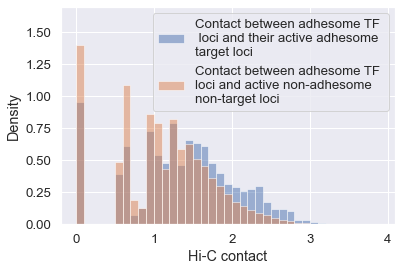

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=20.1337964614463, pvalue=3.732713206924615e-90)


In [143]:
# Compare the contacts between adhesome TFs and (i) their adhesome targets, (ii) their non-adhesome targets, 
# (iii) non-adhesome non-target active loci
sns.set(font_scale=1.2)
plt.figure()
plt.hist(
    tf2target_df_adhesome['hic'].values, 
    alpha=0.5, density=True, 
    bins=np.arange(0,4,0.1), 
    label='Contact between adhesome TF \n loci and their active adhesome \ntarget loci'
)
# plt.hist(
#     tf2target_df_nonadhesome['hic'].values, 
#     alpha=0.5, 
#     density=True, 
#     bins=np.arange(0,4,0.1), 
#     label='Contact between adhesome TF loci \n and their non-adhesome target loci'
# )
plt.hist(
    tf2target_df_nontarget['hic'].values, 
    alpha=0.5, 
    density=True, 
    bins=np.arange(0,4,0.1), 
    label='Contact between adhesome TF \nloci and active non-adhesome \nnon-target loci'
)

plt.xlabel('Hi-C contact')
plt.ylabel('Density')
# plt.xlim(-0.2,3.5)
plt.ylim(0,1.7)
plt.legend(loc='upper right')
# plt.savefig(saving_main_dir+f'fig_4f_{norm}.pdf', format='pdf')
plt.show()

# Tests
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(tf2target_df_adhesome['hic'].values,
                  tf2target_df_nontarget['hic'].values))

## Co-clustering using contacts between all adhesome TFs and all active adhesome loci

In [131]:
# List of all active non-blacklisted adhesome TF loci
adhesome_tf_genes = tf_char_df[tf_char_df['adj_pval']<50].index.values
adhesome_tf_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in adhesome_tf_genes])))
selected_adhesome_tf_loci = np.unique([loc for loc in adhesome_tf_loci if (loc not in blacklist_list)])
print(f'Number of selected adhesome TF loci = {len(selected_adhesome_tf_loci)}')

Number of selected adhesome TF loci = 29


In [132]:
# Note: check if there is overlap between adhesome TF loci and active adhesome loci
set.intersection(*[set(adhesome_tf_loci), set(active_adhesome_loci)])

set()

In [133]:
# List all active non-blacklisted adhesome loci
selected_adhesome_loci = adhesome_chr_loci[adhesome_chr_loci['gene'].isin(active_adhesome_genes)]['locus_id'].unique()
print(f'Number of selected adhesome loci = {len(selected_adhesome_loci)}')

Number of selected adhesome loci = 274


In [134]:
# List all active non-blacklisted loci
selected_active_loci = np.unique([loc for loc in all_active_loci if (loc not in blacklist_list)])
selected_active_loci = [loc for loc in selected_active_loci 
                        if (loc not in selected_adhesome_loci) and 
                        (loc not in selected_adhesome_tf_loci)]
print(f'Number of selected active loci = {len(selected_active_loci)}')

Number of selected active loci = 6073


In [135]:
# Select random non-adhesome loci
with open(saving_dir+'random_active_non_adhesome_loci.pkl', 'rb') as f:
    random_active_non_adhesome_loci = np.array(pickle.load(f))
random_active_non_adhesome_loci = np.unique([loc for loc in random_active_non_adhesome_loci 
                                             if (loc not in selected_adhesome_tf_loci)])
print(f'Number of random non-adhesome loci = {len(random_active_non_adhesome_loci)}')

Number of random non-adhesome loci = 266


100%|██████████| 231/231 [00:03<00:00, 68.67it/s]


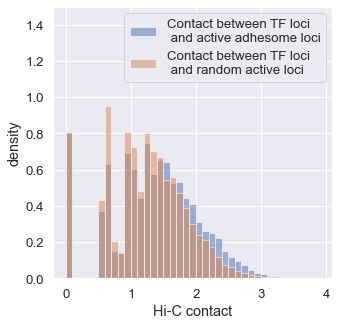

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=11.835957112210341, pvalue=2.5442450697179027e-32)


In [136]:
# Obtain contacts between selected_adhesome_tf_loci and selected_adhesome_loci/random_active_non_adhesome_loci
contacts_tf_adhesome = lu.build_loci_contact_list(dir_processed_hic, 
                                                  selected_adhesome_tf_loci, 
                                                  selected_adhesome_loci)
contacts_tf_random = lu.build_loci_contact_list(dir_processed_hic, 
                                                selected_adhesome_tf_loci, 
                                                random_active_non_adhesome_loci)

# Histogram
sns.set(font_scale=1.2)
plt.figure(figsize=(5,5))
plt.hist(contacts_tf_adhesome, alpha=0.5, density=True, bins=np.arange(0,4,0.1), 
         label='Contact between TF loci \n and active adhesome loci')
plt.hist(contacts_tf_random, alpha=0.5, density=True, bins=np.arange(0,4,0.1), 
         label='Contact between TF loci \n and random active loci')

plt.xlabel('Hi-C contact')
plt.ylabel('density')
# plt.xlim(-0.2,3.5)
plt.ylim(0,1.5)
plt.legend(loc='upper right')
# plt.savefig(saving_main_dir+f'fig_4f_{norm}_all.pdf', format='pdf')
plt.show()

# Tests
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(contacts_tf_adhesome,
                  contacts_tf_random))

100%|██████████| 231/231 [00:05<00:00, 41.65it/s]


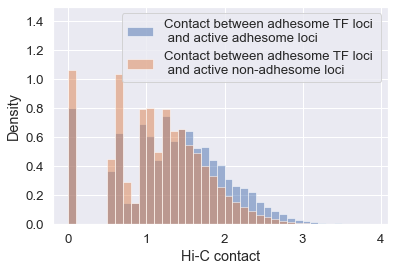

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=26.66647670747072, pvalue=1.1527894071634748e-156)


In [137]:
# Obtain contacts between selected_adhesome_tf_loci and selected_adhesome_loci/selected_active_loci
contacts_tf_adhesome = lu.build_loci_contact_list(dir_processed_hic, 
                                                  selected_adhesome_tf_loci, 
                                                  selected_adhesome_loci)
contacts_tf_nonadhesome = lu.build_loci_contact_list(dir_processed_hic, 
                                                     selected_adhesome_tf_loci, 
                                                     selected_active_loci)

# Histogram
sns.set(font_scale=1.2)
plt.figure()
plt.hist(contacts_tf_adhesome, alpha=0.5, density=True, bins=np.arange(0,4,0.1), 
         label='Contact between adhesome TF loci \n and active adhesome loci')
plt.hist(contacts_tf_nonadhesome, alpha=0.5, density=True, bins=np.arange(0,4,0.1), 
         label='Contact between adhesome TF loci \n and active non-adhesome loci')

plt.xlabel('Hi-C contact')
plt.ylabel('Density')
# plt.xlim(-0.2,3.5)
plt.ylim(0,1.5)
plt.legend(loc='upper right')
# plt.savefig(saving_main_dir+f'fig_4f_{norm}.pdf', format='pdf')
plt.show()

# Tests
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(contacts_tf_adhesome,
                  contacts_tf_nonadhesome))

# Compare proportion of adhesome genes targeted by active TFs in different cell lines

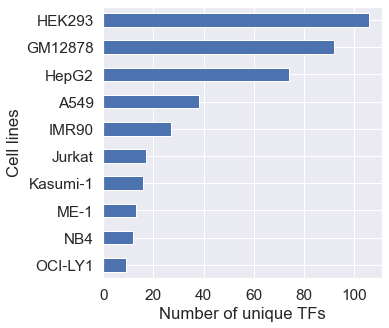

In [35]:
# Number of unique TFs in top cell lines
sns.set(font_scale=1.4)
tftarget_df.groupby('cell_line')['tf'].nunique().sort_values()[-10:].plot.barh(figsize=(5,5))
plt.xlabel('Number of unique TFs')
plt.ylabel('Cell lines')
# plt.savefig(saving_supp_dir+f'suppfig_6a.pdf', format='pdf')
plt.show()

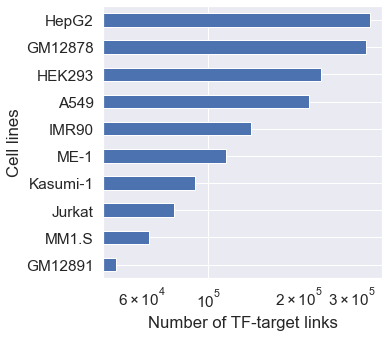

In [36]:
# Number of unique TF-target links in top cell lines
sns.set(font_scale=1.4)
tftarget_df.drop_duplicates(subset=['tf', 'target_gene', 'cell_line'], keep='first').groupby('cell_line')['tf'].count().sort_values()[-10:].plot.barh(figsize=(5,5))
plt.xscale('log')
plt.xlabel('Number of TF-target links')
plt.ylabel('Cell lines')
# plt.savefig(saving_supp_dir+f'suppfig_6b.pdf', format='pdf')
plt.show()

In [37]:
# For each selected cell line, determine the adhesome TFs and their proportion of adhesome targets
selected_cell_lines = ['lung fib', 'GM12878', 'HEK293', 'A549', 'HepG2']
selected_tftarget_df = tftarget_df.copy()
selected_tftarget_df['cell_line'] = selected_tftarget_df['cell_line'].str.replace('IMR90', 'lung fib')
selected_tftarget_df['cell_line'] = selected_tftarget_df['cell_line'].str.replace('WI38', 'lung fib')
selected_tftarget_df['cell_line'] = selected_tftarget_df['cell_line'].str.replace('AG04450', 'lung fib')
selected_tftarget_df['cell_line'] = selected_tftarget_df['cell_line'].str.replace('HPF', 'lung fib')
selected_tftarget_df['cell_line'] = selected_tftarget_df['cell_line'].str.replace('NHLF', 'lung fib')
selected_tftarget_df = selected_tftarget_df[(selected_tftarget_df['cell_line'].isin(selected_cell_lines))]
selected_tftarget_df = selected_tftarget_df.drop_duplicates(subset=['tf', 'target_gene', 'cell_line'], keep='first')
selected_tftarget_df['adhesome_target'] = selected_tftarget_df['target_gene'].isin(active_adhesome_genes)
selected_tftarget_df['adhesome_target'] = selected_tftarget_df['adhesome_target'].astype(int)
selected_tftarget_df = selected_tftarget_df.groupby(['cell_line','tf'])['adhesome_target'].sum()
selected_tftarget_df = selected_tftarget_df/len(active_adhesome_genes)
selected_tftarget_df = selected_tftarget_df.reset_index()
cat_type = pd.api.types.CategoricalDtype(categories=['lung fib', 'A549', 'HepG2', 'GM12878', 'HEK293'], 
                                         ordered=True)
selected_tftarget_df['cell_line'] = selected_tftarget_df['cell_line'].astype(cat_type)

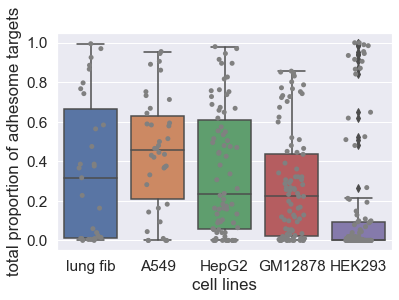

In [38]:
# Plot boxplot per cell line
sns.set(font_scale=1.4)
plt.figure()
sns.boxplot(x='cell_line', y='adhesome_target', data=selected_tftarget_df)
sns.stripplot(x='cell_line', y='adhesome_target', order=['lung fib', 'A549', 'HepG2', 'GM12878', 'HEK293'],
              data=selected_tftarget_df, jitter=0.2, color='grey', alpha=1)
plt.xlabel('cell lines')
plt.ylabel('total proportion of adhesome targets')
plt.show()

In [39]:
# Construct dataframe of proportion of adhesome targets for TFs in different cell lines
selected_cell_lines = ['lung fib', 'GM12878', 'HEK293', 'A549', 'HepG2']
selected_tftarget_df = tftarget_df.copy()
selected_tftarget_df['cell_line'] = selected_tftarget_df['cell_line'].str.replace('IMR90', 'lung fib')
selected_tftarget_df['cell_line'] = selected_tftarget_df['cell_line'].str.replace('WI38', 'lung fib')
selected_tftarget_df['cell_line'] = selected_tftarget_df['cell_line'].str.replace('AG04450', 'lung fib')
selected_tftarget_df['cell_line'] = selected_tftarget_df['cell_line'].str.replace('HPF', 'lung fib')
selected_tftarget_df['cell_line'] = selected_tftarget_df['cell_line'].str.replace('NHLF', 'lung fib')
selected_tftarget_df = selected_tftarget_df[(selected_tftarget_df['cell_line'].isin(selected_cell_lines))]
selected_tftarget_df['adhesome_target'] = selected_tftarget_df['target_gene'].isin(all_adhesome_genes)
prop_adh_target_df = selected_tftarget_df.drop_duplicates(['tf', 'target_gene', 'cell_line'])
prop_adh_target_df = prop_adh_target_df.groupby(['tf', 'cell_line'])['adhesome_target'].sum().reset_index()
prop_adh_target_df['adhesome_target'] = prop_adh_target_df['adhesome_target']/len(all_adhesome_genes)
df_list = []
for c in selected_cell_lines:
    df = prop_adh_target_df[prop_adh_target_df['cell_line']==c][['tf', 'adhesome_target']]
    df.columns = ['tf', f'adhesome target ({c})']
    df = df.set_index('tf')
    df_list.append(df)
combined_result = pd.concat(df_list, axis=1, join="outer")
combined_result = combined_result.fillna(0)
selected_result = combined_result[combined_result['adhesome target (lung fib)']>-0.1] 
selected_result = selected_result[(selected_result['adhesome target (GM12878)']>-0.1) | 
                                   (selected_result['adhesome target (HEK293)']>-0.1) |
                                   (selected_result['adhesome target (A549)']>-0.1) |
                                    (selected_result['adhesome target (HepG2)']>-0.1)]
selected_result = selected_result.sort_values(['adhesome target (lung fib)'], ascending=False)
selected_result.columns = ['Lung fibroblasts', 'GM12878', 'HEK293', 'A549', 'HepG2']

In [40]:
selected_result

,Lung fibroblasts,GM12878,HEK293,A549,HepG2
tf,,,,,
LMNB1,0.995495,0.000000,0.000000,0.000000,0.000000
MAZ,0.941441,0.432432,0.000000,0.000000,0.797297
POLR2A,0.887387,0.842342,0.000000,0.914414,0.882883
CTCF,0.860360,0.860360,0.986486,0.905405,0.909910
CEBPB,0.855856,0.022523,0.000000,0.662162,0.495495
...,...,...,...,...,...
ZEB1,0.000000,0.527027,0.000000,0.000000,0.247748
ZNF143,0.000000,0.265766,0.000000,0.000000,0.000000
ZNF18,0.000000,0.000000,0.184685,0.000000,0.000000


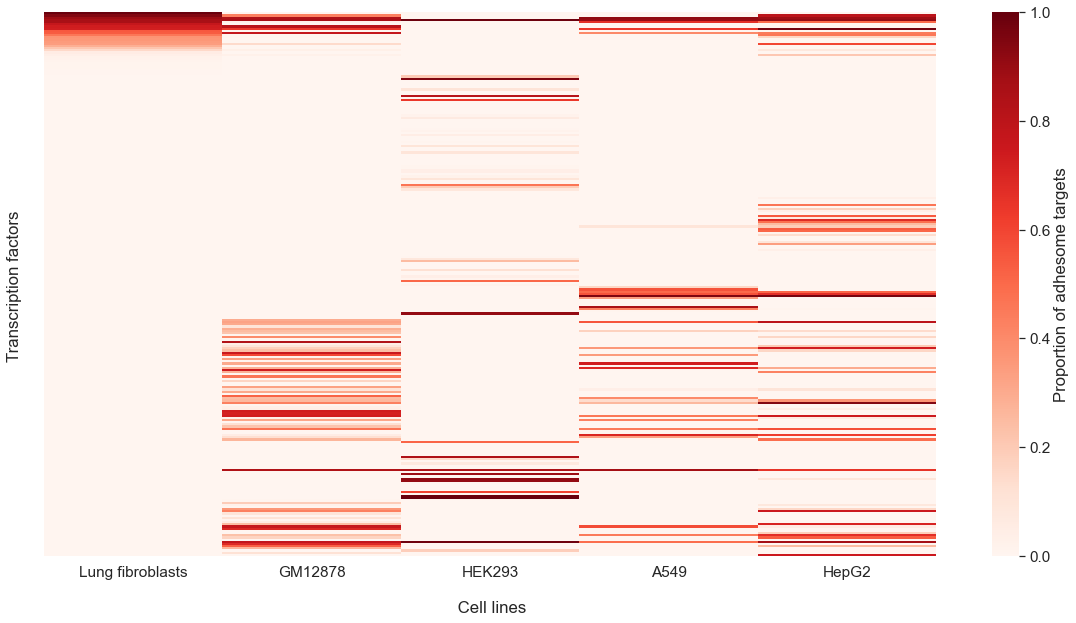

In [41]:
# If we want a heatmap
sns.set(font_scale=1.4)
plt.figure(figsize=(20,10))
sns.heatmap(data=selected_result, yticklabels=False,
            cmap='Reds', cbar_kws={'label': 'Proportion of adhesome targets'})
plt.ylabel('Transcription factors \n')
plt.xlabel('\n Cell lines')
plt.show()

# If we want a clustered heatmap
# plt.figure()
# heatmap_plot = sns.clustermap(data=selected_result,
#                row_cluster=True, col_cluster=False,
#                metric='euclidean', method='average',
#                cmap='Reds',
#                figsize=(10,80))
# heatmap_plot.cax.set_position([1,0.7,0.02,0.1])
# plt.show()

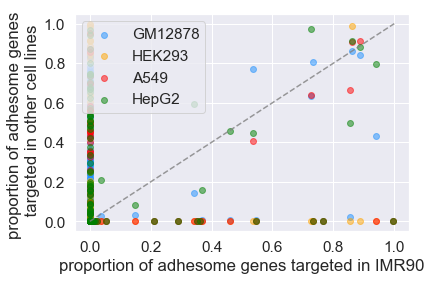

In [42]:
# Scatter plot of proportion of adhesome targets for TFs in different cell lines
sns.set(font_scale=1.4)
plt.figure()
plt.scatter(selected_result['Lung fibroblasts'], selected_result['GM12878'], 
            color='dodgerblue', alpha=0.5, label='GM12878')
plt.scatter(selected_result['Lung fibroblasts'], selected_result['HEK293'], 
            color='orange', alpha=0.5, label='HEK293')
plt.scatter(selected_result['Lung fibroblasts'], selected_result['A549'], 
            color='red', alpha=0.5, label='A549')
plt.scatter(selected_result['Lung fibroblasts'], selected_result['HepG2'], 
            color='green', alpha=0.5, label='HepG2')
plt.plot([0,1], [0,1], color='grey', linestyle='dashed', alpha=0.8)
plt.xlabel('proportion of adhesome genes targeted in IMR90')
plt.ylabel('proportion of adhesome genes \n targeted in other cell lines')
plt.legend(loc='upper left')
plt.savefig(saving_supp_dir+f'suppfig_6c.pdf', format='pdf')
plt.show()

In [43]:
selected_result[selected_result['adhesome target (lung fib)']>0].to_csv(saving_dir+'prop_adhesome_target.csv', sep=',', header=True)

KeyError: 'adhesome target (lung fib)'

In [44]:
selected_result[selected_result['Lung fibroblasts']>0]

,Lung fibroblasts,GM12878,HEK293,A549,HepG2
tf,,,,,
LMNB1,0.995495,0.000000,0.000000,0.000000,0.000000
MAZ,0.941441,0.432432,0.000000,0.000000,0.797297
POLR2A,0.887387,0.842342,0.000000,0.914414,0.882883
CTCF,0.860360,0.860360,0.986486,0.905405,0.909910
CEBPB,0.855856,0.022523,0.000000,0.662162,0.495495
RB1,0.765766,0.000000,0.000000,0.000000,0.000000
SPI1,0.734234,0.806306,0.000000,0.000000,0.000000
RAD21,0.725225,0.635135,0.000000,0.639640,0.972973
CHD1,0.545045,0.004505,0.000000,0.000000,0.000000


### Focus on the case of GM12878

In [45]:
# Load active and inactive genes in GM12878
all_genes_GM12878 = pickle.load(open(saving_dir+'all_genes_GM12878.pkl', 'rb'))
active_genes_GM12878 = pickle.load(open(saving_dir+'active_genes_GM12878.pkl', 'rb'))
inactive_genes_GM12878 = pickle.load(open(saving_dir+'inactive_genes_GM12878.pkl', 'rb'))

In [46]:
# Check TFs expressed in GM12878
tftarget_df_GM12878 = selected_tftarget_df[(selected_tftarget_df['cell_line']=='GM12878')]
tftarget_df_GM12878['active_tf'] = [tf in active_genes_GM12878 for tf in tftarget_df_GM12878['tf'].values]
tftarget_df_GM12878 = tftarget_df_GM12878.sort_values('adhesome_target')
n_adhesome_tfs = tftarget_df_GM12878[
    tftarget_df_GM12878['adhesome_target']
]['tf'].nunique()
n_active_adhesome_tfs = tftarget_df_GM12878[
    tftarget_df_GM12878['active_tf'] & tftarget_df_GM12878['adhesome_target']
]['tf'].nunique()
print(f'{n_active_adhesome_tfs} adhesome TF genes are active in GM12878 out of {n_adhesome_tfs}.')

80 adhesome TF genes are active in GM12878 out of 81.


### Focus on the case of HEK293

In [ ]:
# Load active and inactive genes in HEK293
all_genes_HEK293 = pickle.load(open(saving_dir+'all_genes_HEK293.pkl', 'rb'))
active_genes_HEK293 = pickle.load(open(saving_dir+'active_genes_HEK293.pkl', 'rb'))
inactive_genes_HEK293 = pickle.load(open(saving_dir+'inactive_genes_HEK293.pkl', 'rb'))

In [ ]:
# Check TFs expressed in GM12878
tftarget_df_HEK293 = selected_tftarget_df[(selected_tftarget_df['cell_line']=='HEK293')]
tftarget_df_HEK293['active_tf'] = [tf in active_genes_GM12878 for tf in tftarget_df_HEK293['tf'].values]
tftarget_df_HEK293 = tftarget_df_HEK293.sort_values('adhesome_target')
n_active_adhesome_tfs = tftarget_df_HEK293['active_tf'].sum()
print(f'{n_active_adhesome_tfs} adhesome TF genes are active in GM12878 out of {len(tftarget_df_HEK293)}.')

In [ ]:
# Function to list all contacts between 2 sets of loci
loci_list1 = []
loci_list2 = []
contact_list = []
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.product(chr_list, chr_list))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair
    
    if chr1 == chr2:
        continue

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_list1 if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_list2 if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    with open(dir_processed_hic+processed_hic_filename, 'rb') as f:
        hic_chpair_df = pickle.load(f)

    # Fill in corresponding submatrix of gene_contacts_df by sum of 
    # Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        contact_list.append(hic_chpair_df.loc[locus1,locus2])
        

In [ ]:
# Compute corresponding Hi-C matrix
contacts_df = pd.DataFrame(0, index=loci_list, columns=loci_list)
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_list if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_list if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    with open(dir_processed_hic+processed_hic_filename, 'rb') as f:
        hic_chpair_df = pickle.load(f)

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        contacts_df.loc[locus1_id, locus2_id] = hic_chpair_df.loc[locus1,locus2]
# Symmetrize data frame
contacts_df1 = contacts_df+contacts_df.T
# Save to pickle
with open(saving_dir+'contacts_df_tf.pkl', 'wb') as f:
    pickle.dump(contacts_df1, f)